In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import fitz  # PyMuPDF
import cv2
import pytesseract
import numpy as np
import os
import csv
import re
import pandas as pd


In [ ]:
from pdf_image_extractor import PDFImageExtractor
from pdf_page_processor import Page
from column_names_detector import ColumnLineDetector
from column_values_detector import ColumnValuesDetector

# Путь к PDF файлу и путь к Tesseract
NUM_PAGE = 132
pdf_path = 'Kogan_1.pdf'
tesseract_path = 'C:/Program Files/Tesseract-OCR/tesseract.exe'
image = PDFImageExtractor(pdf_path, tesseract_path, images_folder=f'pdf_data/page_{NUM_PAGE}')        
page = Page(NUM_PAGE, image)
column_names_area = ColumnLineDetector( # переименовать класс в column_names_area
    'extracted_images\page_132_processed.png', page.text, debug=True).detect_column_names_area()
column_values_area = ColumnValuesDetector( # переименовать класс в column_values_area
    'extracted_images\page_132_processed.png', page.text, debug=True).detect_column_values_area()

Обработка страницы 132...
Начало функции detect_column_values_area
Найдено вертикальных линий: 232
Линии после объединения: 220
Линии после фильтрации: 33
Отладка включена, начинаем отрисовку линий и сохранение гистограмм
Изображение с линиями сохранено: debug_column_values_area.png
Гистограммы сохранены: debug_histograms.png
Данные гистограммы сохранены в CSV: histogram_data.csv
Завершение функции detect_column_values_area


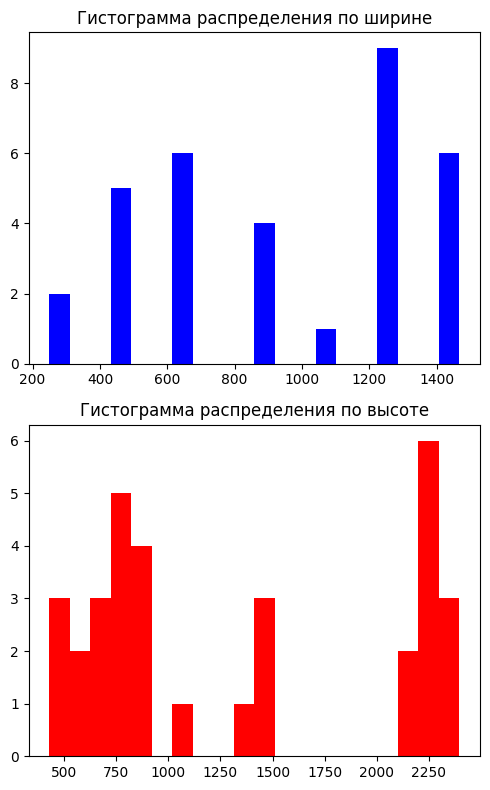

In [2]:
from pdf_image_extractor import PDFImageExtractor
from column_names_detector import ColumnLineDetector
from column_values_detector import ColumnValuesDetector
from group_grouper import GaussianCurveGrouper

# Путь к PDF файлу и путь к Tesseract
pdf_path = 'Kogan_1.pdf'
tesseract_path = 'C:/Program Files/Tesseract-OCR/tesseract.exe'
extractor = PDFImageExtractor(pdf_path, tesseract_path)

extractor.extract_images_from_pdf(start_page=131, end_page=132)
extractor.extract_text_from_images(start_page=131, end_page=132)
column_names_area = ColumnLineDetector( # переименовать класс в column_names_area
    'extracted_images\page_132_processed.png', extractor.text, debug=True).detect_column_names_area()
column_values_area = ColumnValuesDetector( # переименовать класс в column_values_area
    'extracted_images\page_132_processed.png', extractor.text, debug=True).detect_column_values_area()


grouper = GaussianCurveGrouper(
    hystogram_data='histogram_data.csv', 
    ocr_text_path="extracted_images/extracted_text.txt", 
    regex_pattern=r"([NnеНЕмт№]\s?\d*\.?\d*\s?.*?\[.*?\])"
    )
grouped_data = grouper.group_data()

In [5]:
grouped_data

[[400.0,
  450.0,
  550.0,
  600.0,
  650.0,
  700.0,
  750.0,
  800.0,
  850.0,
  900.0,
  1050.0,
  1300.0,
  1450.0,
  1500.0],
 [2100.0, 2200.0, 2250.0, 2350.0]]

In [4]:
def count_matching_lines(filename, pattern):
    # Счётчик строк, соответствующих шаблону
    count = 0

    # Открываем файл и читаем его построчно
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            # Проверяем, соответствует ли строка шаблону
            if re.search(pattern, line):
                count += 1

    return count

def group_data_by_gaussian_curves(filename, n_curves):
    MIN_DISTANCE = 500
    AGGREGATION_STEP = 50
    # Загрузка данных
    df = pd.read_csv(filename)

    # Создание нового столбца для агрегированных значений
    df['Center_Y_Aggregated'] = (df['Center_Y'] // AGGREGATION_STEP) * AGGREGATION_STEP

    # Подсчет количества вхождений для каждой агрегированной категории
    aggregated_counts = df['Center_Y_Aggregated'].value_counts().sort_index()    

    # Поиск наибольших точек    
    point = aggregated_counts.sort_values(ascending=False).index[0]
    other_points = [value for value in aggregated_counts.sort_values(ascending=False).index if abs(value - point) > MIN_DISTANCE]
    points = [point, *other_points]
    valid_points = points[:n_curves]

    if len(valid_points) < n_curves:
        raise ValueError("Не удалось найти достаточное количество точек, удовлетворяющих условиям.")

    # Функция для гауссианы
    def gaussian(x, mu, sigma, height):
        return height * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

    # Разделение значений на группы
    groups = [[] for _ in range(n_curves)]
    for idx in aggregated_counts.index:
        gauss_values = [gaussian(idx, point, 500, aggregated_counts[point]) for point in valid_points]
        assigned_group = np.argmax(gauss_values)
        groups[assigned_group].append(idx)

    return groups


# Регулярное выражение, заданное в запросе
general_regex = r"([NnеНЕмт№]\s?\d*\.?\d*\s?.*?\[.*?\])"
grouped_data = group_data_by_gaussian_curves(
    'histogram_data.csv', 
    count_matching_lines("extracted_images/extracted_text.txt", general_regex))
# Повторное тестирование функции с исправлением

grouped_data



[[400.0,
  450.0,
  550.0,
  600.0,
  650.0,
  700.0,
  750.0,
  800.0,
  850.0,
  900.0,
  1050.0,
  1300.0,
  1450.0,
  1500.0],
 [2100.0, 2200.0, 2250.0, 2350.0]]

In [39]:
import pandas as pd
import numpy as np


def group_data_by_gaussian_curves(filename, n_curves):
    MIN_DISTANCE = 500
    AGGREGATION_STEP = 50
    # Загрузка данных
    df = pd.read_csv(filename)

    # Создание нового столбца для агрегированных значений
    df['Center_Y_Aggregated'] = (df['Center_Y'] // AGGREGATION_STEP) * AGGREGATION_STEP

    # Подсчет количества вхождений для каждой агрегированной категории
    aggregated_counts = df['Center_Y_Aggregated'].value_counts().sort_index()    

    # Поиск наибольших точек    
    point = aggregated_counts.sort_values(ascending=False).index[0]
    other_points = [value for value in aggregated_counts.sort_values(ascending=False).index if abs(value - point) > MIN_DISTANCE]
    points = [point, *other_points]
    valid_points = points[:n_curves]

    if len(valid_points) < n_curves:
        raise ValueError("Не удалось найти достаточное количество точек, удовлетворяющих условиям.")

    # Функция для гауссианы
    def gaussian(x, mu, sigma, height):
        return height * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

    # Разделение значений на группы
    groups = [[] for _ in range(n_curves)]
    for idx in aggregated_counts.index:
        gauss_values = [gaussian(idx, point, 500, aggregated_counts[point]) for point in valid_points]
        assigned_group = np.argmax(gauss_values)
        groups[assigned_group].append(idx)

    return groups

# Повторное тестирование функции с исправлением
grouped_data_fixed = group_data_by_gaussian_curves('histogram_data.csv', 2)
grouped_data_fixed

[[300.0,
  400.0,
  450.0,
  500.0,
  600.0,
  700.0,
  750.0,
  800.0,
  850.0,
  1050.0,
  1150.0,
  1250.0,
  1300.0,
  1450.0,
  1500.0],
 [2100.0, 2200.0, 2250.0, 2300.0, 2350.0]]